In [ ]:
!pip install pandas sqlalchemy pmdarima prophet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.5 MB/s eta 0:00:00


**Mount Google Drive**

**Install Necessary Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Load the Rossmann Store Sales Dataset**


In [ ]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/LGPS internship project/rossmann-store-sales/train.csv')
df['Date'] = pd.to_datetime(df['Date'])


<ipython-input-22-a8589641c917>:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/LGPS internship project/rossmann-store-sales/train.csv')


**Import Libraries**

In [ ]:
import sqlite3
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from prophet import Prophet


In [ ]:
print(df.columns)

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')


In [ ]:
print(df.head())


   Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  


In [ ]:
df.rename(columns={'incorrect_column_name': 'date'}, inplace=True)


In [ ]:
# Check the columns
print(df.columns)

# Check the first few rows of the DataFrame
print(df.head())

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')
   Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  


In [ ]:
# Rename columns if necessary
df.rename(columns={'incorrect_column_name_store': 'store', 'incorrect_column_name_sales': 'sales'}, inplace=True)

In [ ]:
# Fetch data for a specific store (e.g., Store 1)
store_id = 1
df_store = df[df['Store'] == store_id]
df_store = df_store[['Date', 'Sales']]
df_store = df_store[df_store['Sales'] > 0]

In [ ]:
# Ensure the date column is in datetime format
df_store['Date'] = pd.to_datetime(df_store['Date'])

In [ ]:
# Set the date column as the index
df_store.set_index('Date', inplace=True)

In [ ]:
# Sort the data by date
df_store.sort_index(inplace=True)


In [ ]:
# Perform seasonal decomposition
result = seasonal_decompose(df_store['Sales'], model='multiplicative', period=365)


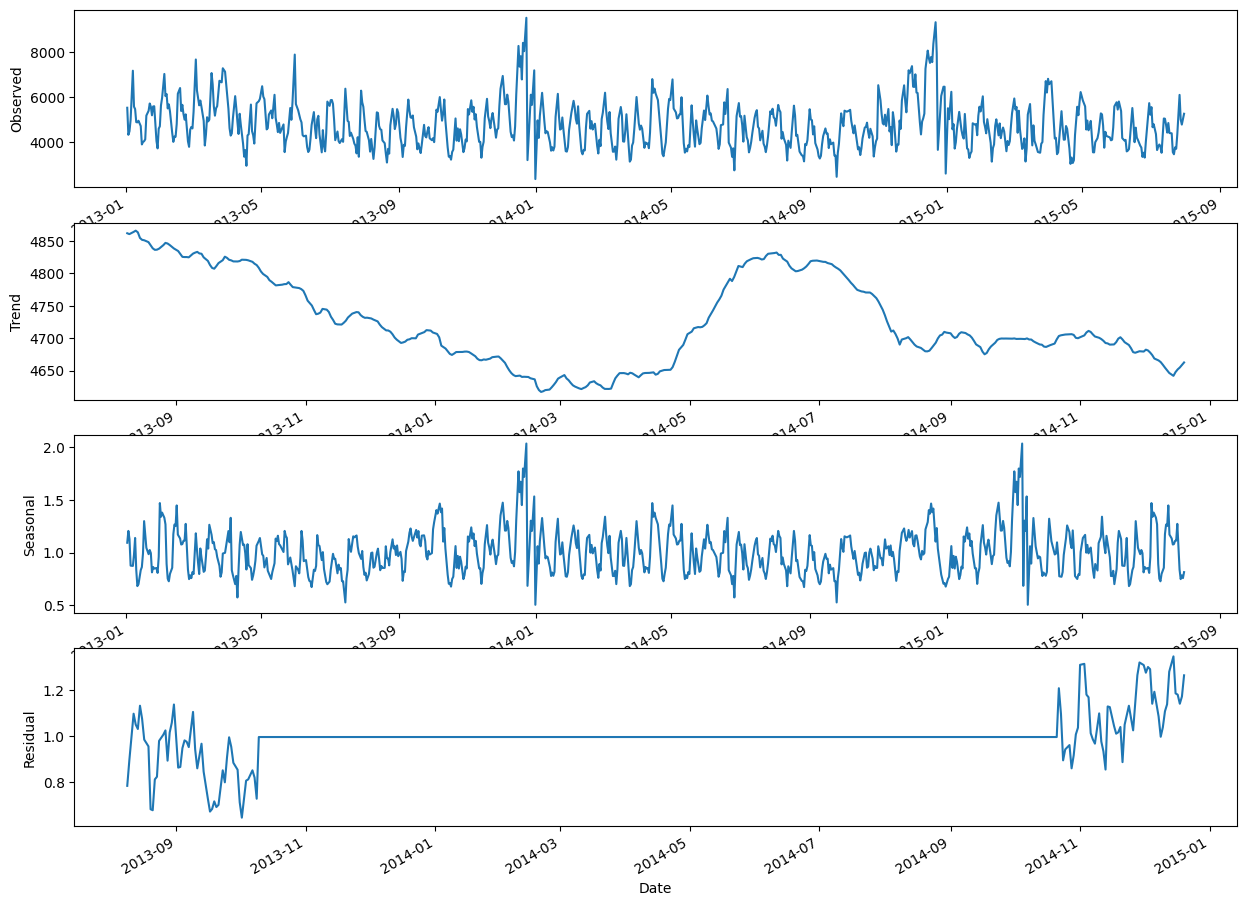

In [ ]:
# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
plt.show()

**Create SQLite Database and Table**

In [ ]:
# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('retail_sales.db')
cursor = conn.cursor()

In [ ]:
# Create sales_data table
cursor.execute('''
CREATE TABLE IF NOT EXISTS sales_data (
    Store INTEGER,
    Date TEXT NOT NULL,
    Sales REAL NOT NULL,
    PRIMARY KEY (Store, Date)
)
''')
conn.commit()

In [ ]:
# Insert data into the database
df.to_sql('sales_data', conn, if_exists='replace', index=False)

1017209

**Fetch Data from Database and Preprocess**
Fetch Data Using Pandas

In [ ]:
# Fetch data for a specific store (e.g., Store 1)
store_id = 1
query = f"SELECT Date, Sales FROM sales_data WHERE Store = {store_id} AND Sales > 0"
df_store = pd.read_sql(query, conn)

***Step 5: Implement Time Series Forecasting Model Using ARIMA ***

In [ ]:
# Fit ARIMA model
model = auto_arima(df_store['Sales'], seasonal=True, m=12, error_action='ignore', suppress_warnings=True)
print(model.summary())


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  781
Model:             SARIMAX(3, 0, 2)x(1, 0, [1], 12)   Log Likelihood               -6212.447
Date:                              Fri, 28 Jun 2024   AIC                          12442.893
Time:                                      16:18:43   BIC                          12484.839
Sample:                                           0   HQIC                         12459.025
                                              - 781                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1740.2470    487.805      3.568      0.000     784.167    2696.327
ar.L1         -0.97

**Forecast Future Sales**

In [ ]:
# Forecast for the next 30 days
forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
# Create a DataFrame with the forecast results
forecast_dates = pd.date_range(start=df_store.index[-1], periods=30+1, inclusive='right')
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast})

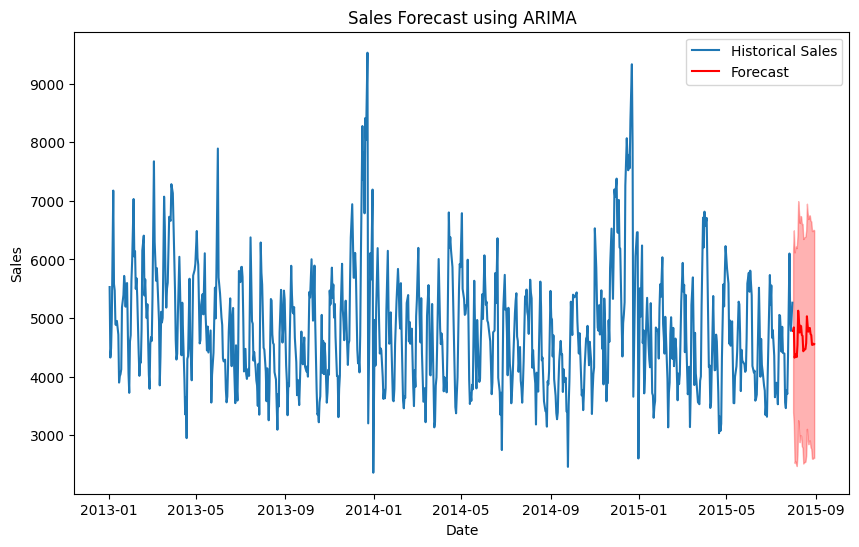

In [ ]:
# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(df_store.index, df_store['Sales'], label='Historical Sales')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_df['Date'], conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast using ARIMA')
plt.legend()
plt.show()

**Store ARIMA Forecast in the Database**

In [ ]:
# Store ARIMA Forecast
forecast_df['Forecast'] = forecast_df['Forecast'].round(2)
forecast_df.to_sql('forecast_data', conn, if_exists='replace', index=False)


30

**Fit Prophet Model**

In [ ]:
# Prophet requires a specific format
df_prophet = df_store.reset_index().rename(columns={'Date': 'ds', 'Sales': 'y'})

In [ ]:
# Fit the model
model = Prophet()
model.fit(df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy30r57n6/rpkkqsh3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy30r57n6/ww1stati.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32400', 'data', 'file=/tmp/tmpy30r57n6/rpkkqsh3.json', 'init=/tmp/tmpy30r57n6/ww1stati.json', 'output', 'file=/tmp/tmpy30r57n6/prophet_modelek6xg_cx/prophet_model-20240628161908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:19:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:19:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


**Forecast Future Sales**

In [ ]:
# Make a future dataframe for the next 30 days
future = model.make_future_dataframe(periods=30)

In [ ]:
# Predict
forecast = model.predict(future)

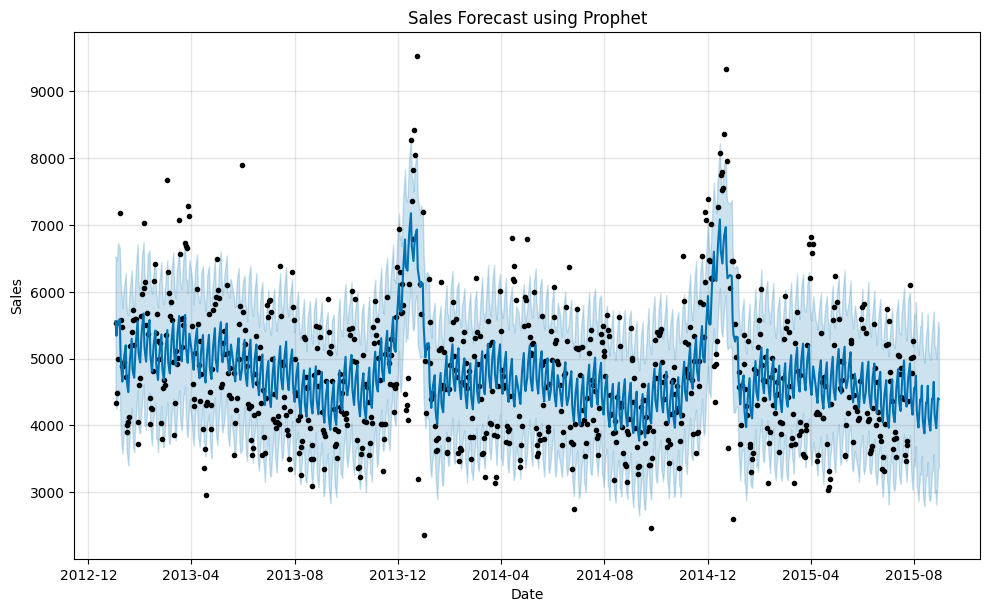

In [ ]:
# Plot the forecast
fig = model.plot(forecast)
plt.title('Sales Forecast using Prophet')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

**Store Prophet Forecast**

In [ ]:
# Select relevant columns from Prophet forecast
prophet_forecast_df = forecast[['ds', 'yhat']].rename(columns={'ds': 'Date', 'yhat': 'Forecast'})
prophet_forecast_df['Forecast'] = prophet_forecast_df['Forecast'].round(2)
prophet_forecast_df.to_sql('prophet_forecast_data', conn, if_exists='replace', index=False)


811

In [ ]:

# Create a connection to the SQLite database
engine = create_engine('sqlite:///retail_sales.db', echo=False)

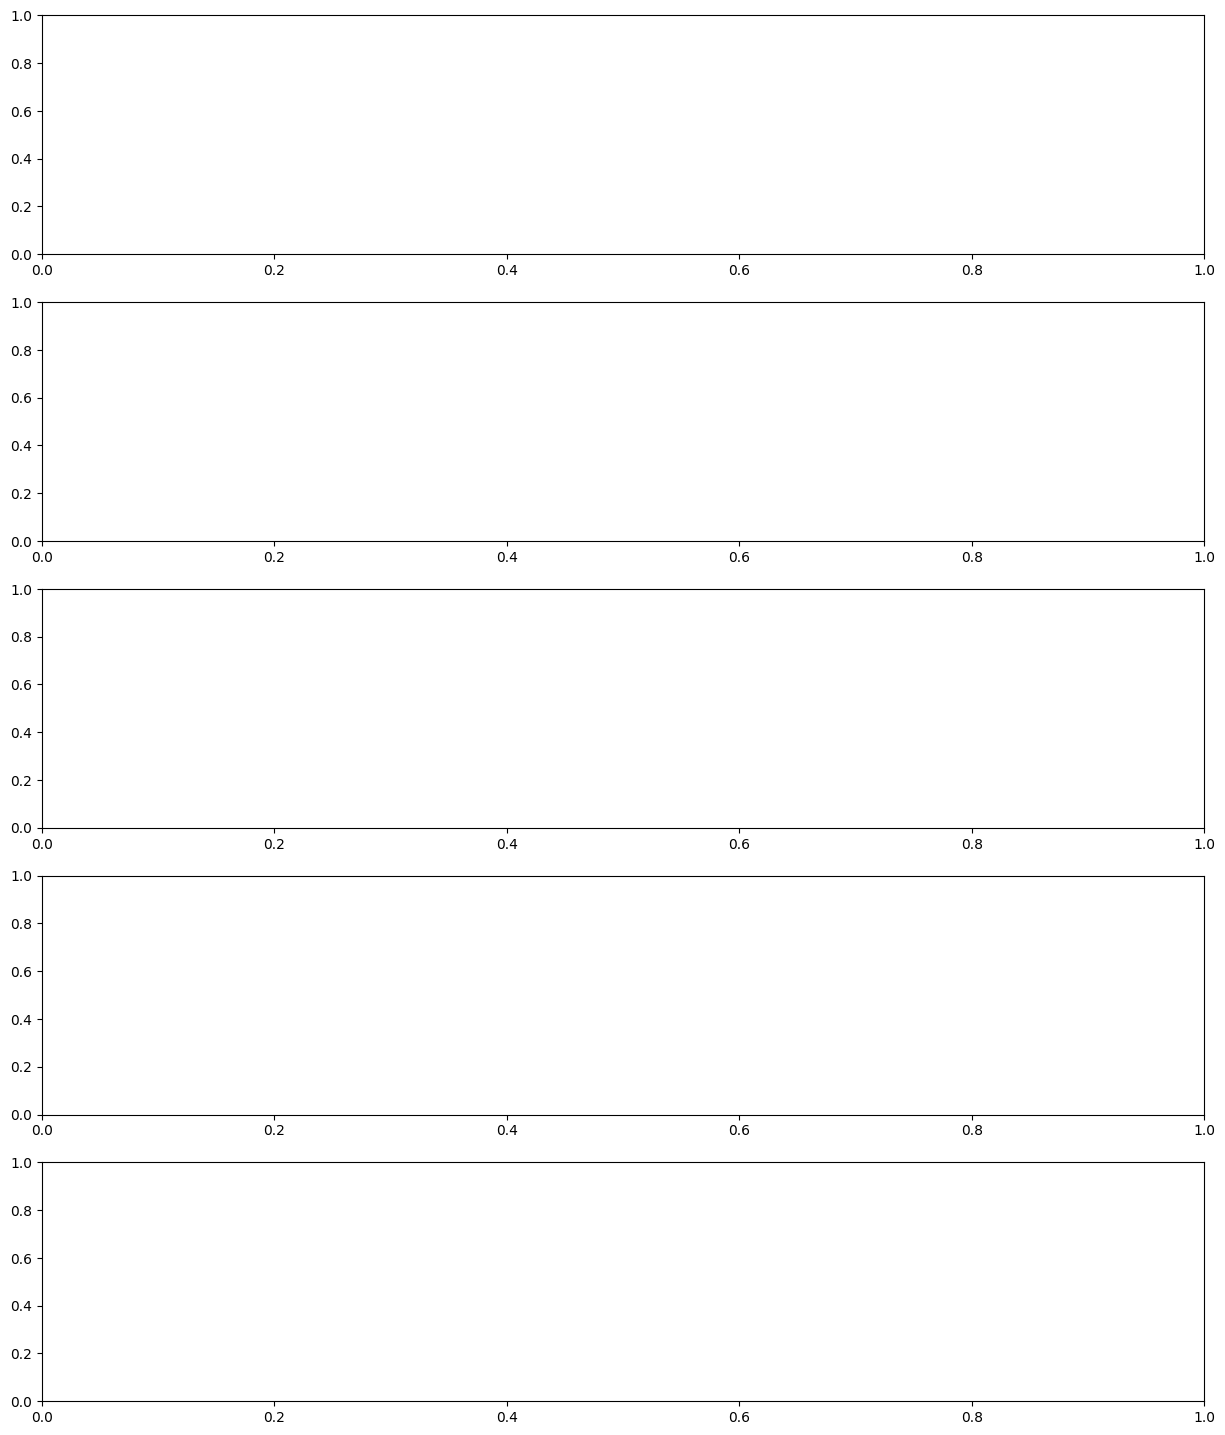

In [ ]:
# Plot the decomposed components and the Prophet forecast
fig, axes = plt.subplots(5, 1, figsize=(15, 18))

In [ ]:
# Seasonal Decomposition plots
result.observed.plot(ax=axes[0])
axes[0].set_ylabel('Observed')
axes[0].set_title('Seasonal Decomposition of Sales Data')

Text(0.5, 1.0, 'Seasonal Decomposition of Sales Data')

In [ ]:
result.trend.plot(ax=axes[1])
axes[1].set_ylabel('Trend')

Text(4.444444444444452, 0.5, 'Trend')

In [ ]:
result.seasonal.plot(ax=axes[2])
axes[2].set_ylabel('Seasonal')

Text(4.444444444444452, 0.5, 'Seasonal')

In [ ]:
result.resid.plot(ax=axes[3])
axes[3].set_ylabel('Residual')

Text(4.444444444444452, 0.5, 'Residual')

In [ ]:
# Prophet forecast plot
axes[4].plot(df_prophet['ds'], df_prophet['y'], label='Historical Sales')
axes[4].plot(prophet_forecast_df['Date'], prophet_forecast_df['Forecast'], label='Forecast', color='red')
axes[4].set_xlabel('Date')
axes[4].set_ylabel('Sales')
axes[4].set_title('Sales Forecast using Prophet')
axes[4].legend()


In [ ]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
!pip install pandas matplotlib seaborn plotly


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from sqlalchemy import create_engine
from statsmodels.tsa.seasonal import seasonal_decompose


In [ ]:
# Example interactive plot with Plotly (adjust based on your data)
fig = px.line(df_store, x=df_store.index, y='Sales', title='Sales Over Time')
fig.show()


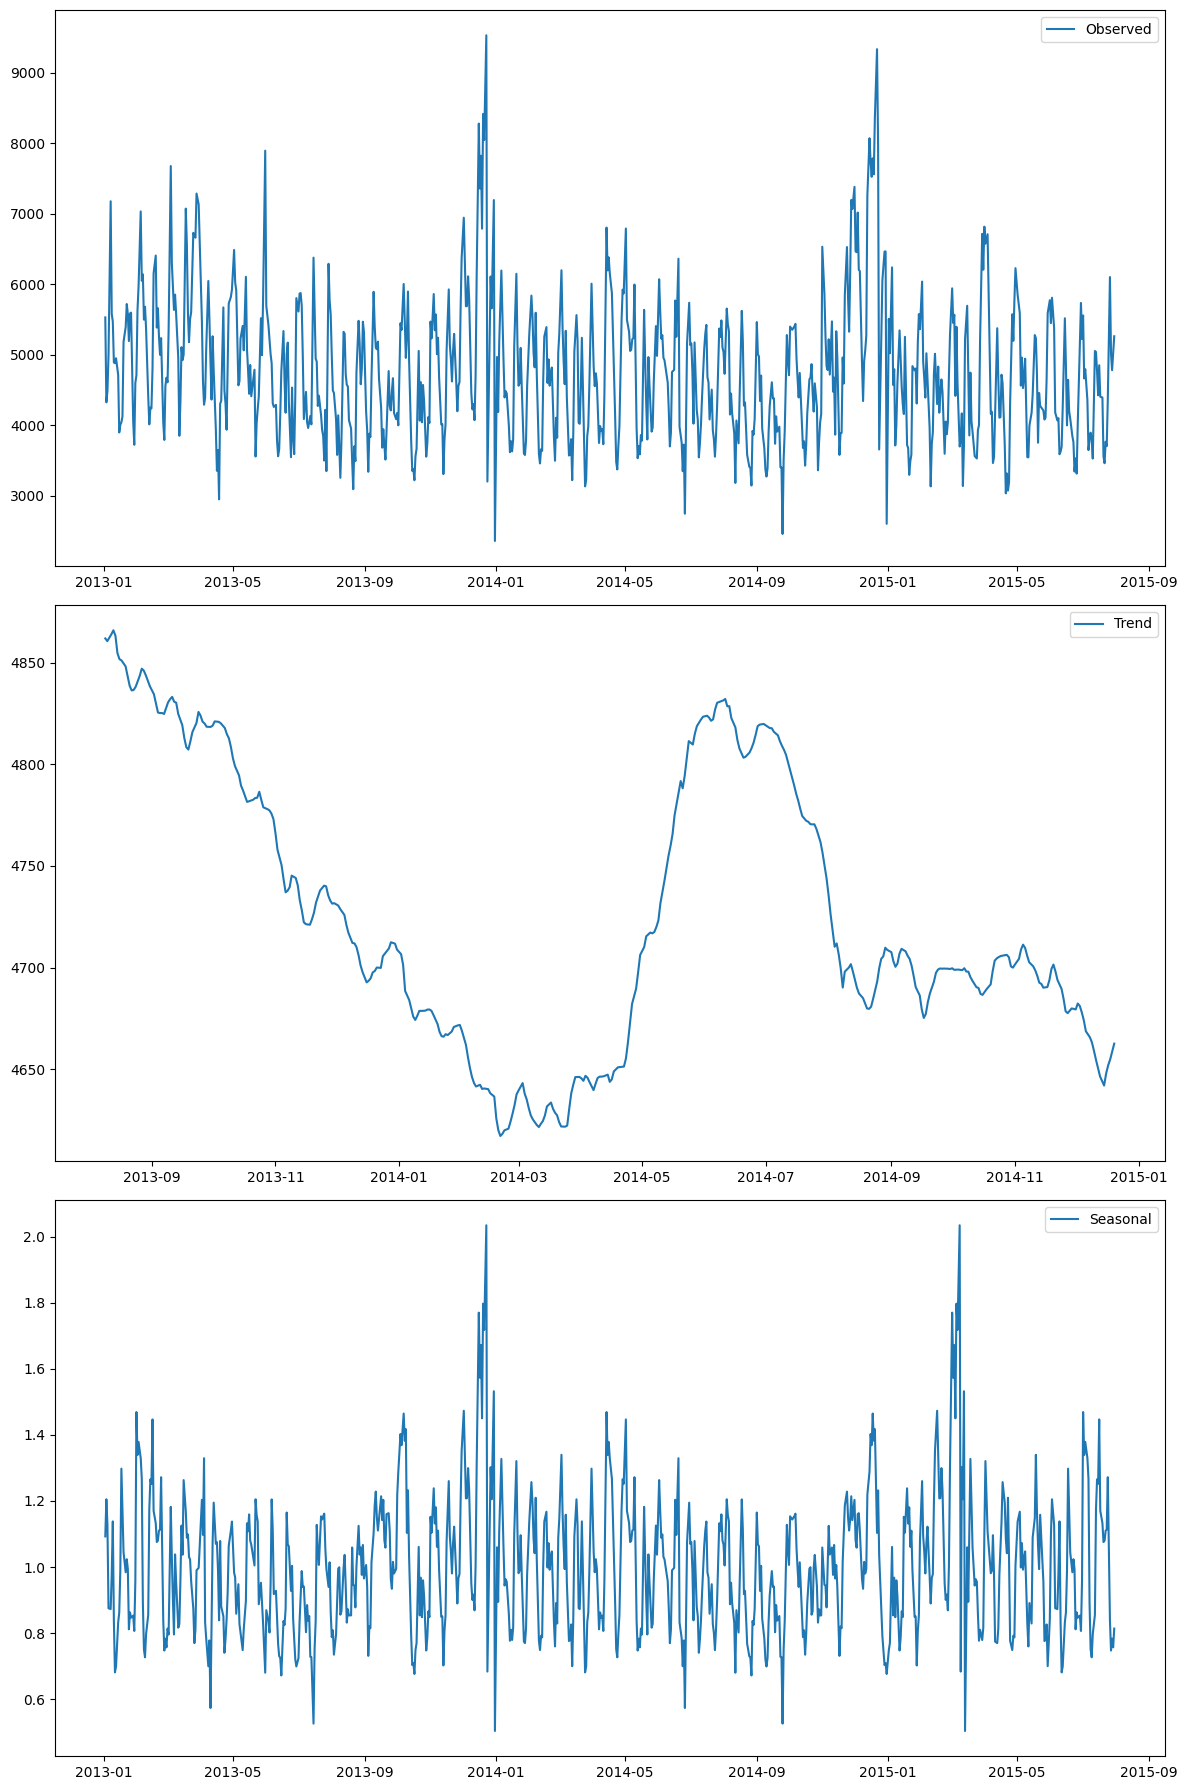

In [ ]:
# Create a dashboard-style layout with subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plot seasonal decomposition
axes[0].plot(result.observed, label='Observed')
axes[0].legend()

axes[1].plot(result.trend, label='Trend')
axes[1].legend()

axes[2].plot(result.seasonal, label='Seasonal')
axes[2].legend()

plt.tight_layout()
plt.show()


In [ ]:
!pip install dash plotly


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 12.6 MB/s eta 0:00:00


In [ ]:
# Import necessary Dash libraries
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objs as go

<ipython-input-86-f430ab105e83>:3: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

<ipython-input-86-f430ab105e83>:4: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`



In [ ]:
# Initialize the Dash app
app = dash.Dash(__name__)


In [ ]:

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the dashboard
app.layout = html.Div([
    html.H1('Sales Analysis Dashboard'),

    # Seasonal Decomposition Plot
    dcc.Graph(
        id='seasonal-decomposition',
        figure={
            'data': [
                {'x': result.observed.index, 'y': result.observed, 'type': 'line', 'name': 'Observed'},
                {'x': result.trend.index, 'y': result.trend, 'type': 'line', 'name': 'Trend'},
                {'x': result.seasonal.index, 'y': result.seasonal, 'type': 'line', 'name': 'Seasonal'},
                {'x': result.resid.index, 'y': result.resid, 'type': 'line', 'name': 'Residual'}
            ],
            'layout': {
                'title': 'Seasonal Decomposition of Sales Data'
            }
        }
    ),

    # Prophet Forecast Plot
    dcc.Graph(
        id='prophet-forecast',
        figure={
            'data': [
                {'x': df_prophet['ds'], 'y': df_prophet['y'], 'type': 'line', 'name': 'Historical Sales'},
                {'x': prophet_forecast_df['Date'], 'y': prophet_forecast_df['Forecast'], 'type': 'line', 'name': 'Forecast'}
            ],
            'layout': {
                'title': 'Sales Forecast using Prophet',
                'xaxis': {'title': 'Date'},
                'yaxis': {'title': 'Sales'}
            }
        }
    )
])

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

<IPython.core.display.Javascript object>

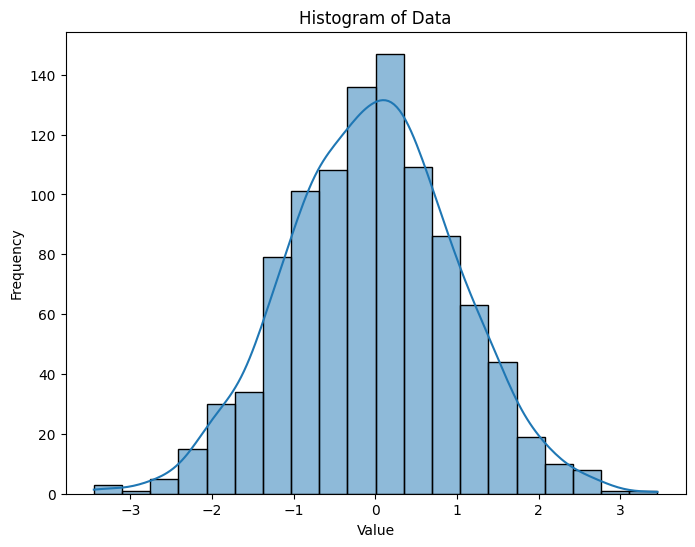

In [ ]:
import numpy as np  # Import NumPy

import seaborn as sns

# Example data for histogram
data = np.random.normal(loc=0, scale=1, size=1000)

# Plotting histogram using seaborn
plt.figure(figsize=(8, 6))  # Adjust figsize as needed
sns.histplot(data, bins=20, kde=True)
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


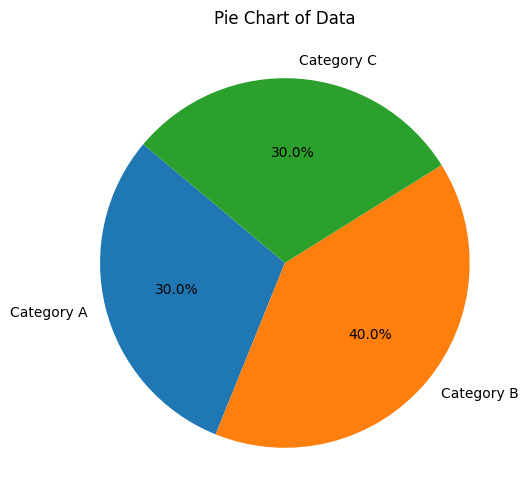

In [ ]:
# Example data for pie chart
labels = ['Category A', 'Category B', 'Category C']
sizes = [30, 40, 30]

# Plotting pie chart using matplotlib
plt.figure(figsize=(6, 6))  # Square figsize
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of Data')
plt.show()


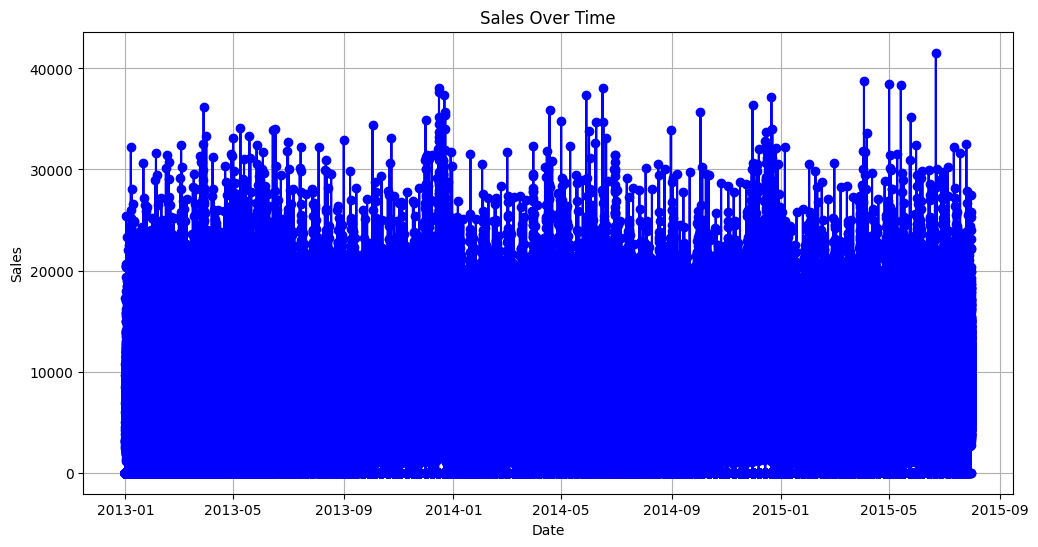

In [ ]:
import matplotlib.pyplot as plt

# Example: Line plot of sales over time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Sales'], marker='o', linestyle='-', color='b')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


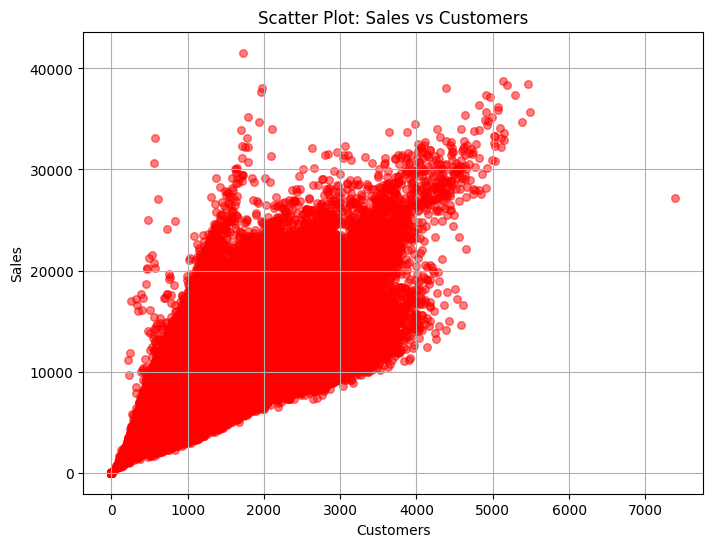

In [ ]:
# Example: Scatter plot of Sales vs Customers
plt.figure(figsize=(8, 6))
plt.scatter(df['Customers'], df['Sales'], color='r', marker='o', s=30, alpha=0.5)
plt.title('Scatter Plot: Sales vs Customers')
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


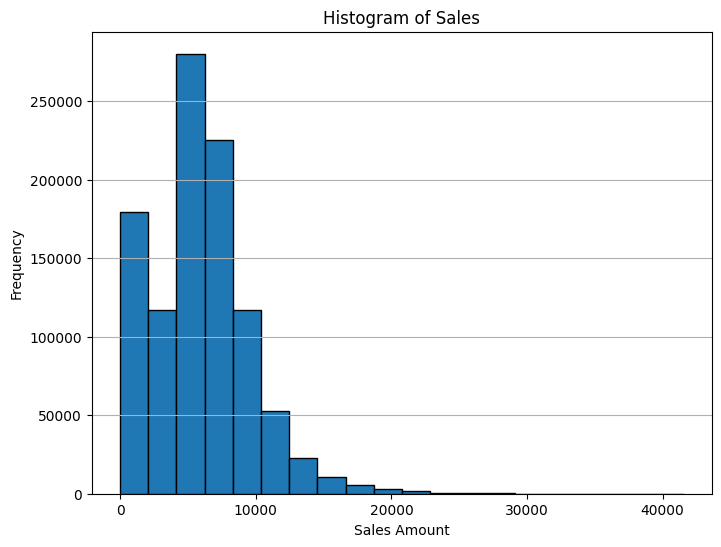

In [ ]:
# Example: Histogram of Sales
plt.figure(figsize=(8, 6))
plt.hist(df['Sales'], bins=20, edgecolor='black')
plt.title('Histogram of Sales')
plt.xlabel('Sales Amount')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()
